# Logistic distribution simulation

In [1]:
library(evd)
library(maxstablePCA)
library(ggplot2)
library(dplyr)
library(GGally)
library(graphicalExtremes)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### setup parameters and simulate data

In [2]:
set.seed(123456789)
s <- 250

In [3]:
Z <- rmvevd(10000, dep = .5, model = "log", d = 2, mar = c(1,1,1))

In [4]:
Z2 <- rmstable(10000, d = 2, par = matrix(c(0, .6, .6, 0), 2, 2))

In [5]:
A <- matrix(c(0.8, 0.05, 0.6, 0.45, 0.2, 0.95, 0.4, 0.55), 4, 2)
X <- t(maxmatmul(A, t(Z)))
X2 <- t(maxmatmul(A, t(Z2)))

In [6]:
A

0.80,0.20
0.05,0.95
0.60,0.40
0.45,0.55


In [9]:
Xtrafo <- transform_unitpareto(X)

# max-stable PCA for X

In [11]:
summary(rowSums(Xtrafo))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    4.00     5.53     8.28    39.15    16.46 40000.00 

In [12]:
length(which(rowSums(Xtrafo) > s))

[1] 166

In [13]:
maxPCA1 <- max_stable_prcomp(Xtrafo, p = 1, s = s, n_initial_guesses = 15000)
maxPCA2 <- max_stable_prcomp(Xtrafo, p = 2, s = s, n_initial_guesses = 15000)
maxPCA3 <- max_stable_prcomp(Xtrafo, p = 3, s = s, n_initial_guesses = 15000)
maxPCA4 <- max_stable_prcomp(Xtrafo, p = 4, s = s, n_initial_guesses = 15000)

### inspect relevant output 

In [14]:
maxPCA2

$p
[1] 2

$d
[1] 4

$decoder_matrix
          [,1]      [,2]
[1,] 1.1309407 0.1886080
[2,] 0.0497363 1.1009284
[3,] 0.9399330 0.6232022
[4,] 0.7355829 0.8239992

$encoder_matrix
           [,1]       [,2]       [,3]       [,4]
[1,] 0.88422511 0.09220151 0.10007825 0.10210594
[2,] 0.02404776 0.90832464 0.04415476 0.06921006

$reconstr_matrix
           [,1]      [,2]       [,3]       [,4]
[1,] 1.00000614 0.1713173 0.11318257 0.11547576
[2,] 0.04397808 1.0000004 0.04861122 0.07619532
[3,] 0.83111239 0.5660699 0.09406686 0.09597274
[4,] 0.65042083 0.7484588 0.07361585 0.07510738

$loss_fctn_value
[1] 0.08985532

$optim_conv_status
[1] 4

$s
[1] 250

$starting_vals
$starting_vals$decoder_matrix_x0
          [,1]      [,2]
[1,] 1.0000000 0.5063524
[2,] 0.2268462 1.0000000
[3,] 0.7601431 0.6656747
[4,] 0.7091768 0.5594043

$starting_vals$encoder_matrix_x0
          [,1]      [,2]      [,3]      [,4]
[1,] 0.9238539 0.6327019 0.1000783 0.5706224
[2,] 0.4854059 0.9951438 0.5318367 0.7954519


a

In [15]:
maxPCA3$optim_conv_status

[1] 4

### report rounded estimated matrices

In [16]:
round(maxPCA2$decoder_matrix, 2)

1.13,0.19
0.05,1.10
0.94,0.62
0.74,0.82


In [17]:
round(maxPCA2$encoder_matrix, 2)

0.88,0.09,0.10,0.10
0.02,0.91,0.04,0.07


In [18]:
round(maxPCA2$reconstr_matrix, 2)

1.00,0.17,0.11,0.12
0.04,1.00,0.05,0.08
0.83,0.57,0.09,0.10
0.65,0.75,0.07,0.08


# Elbow plot for reconstruction error 

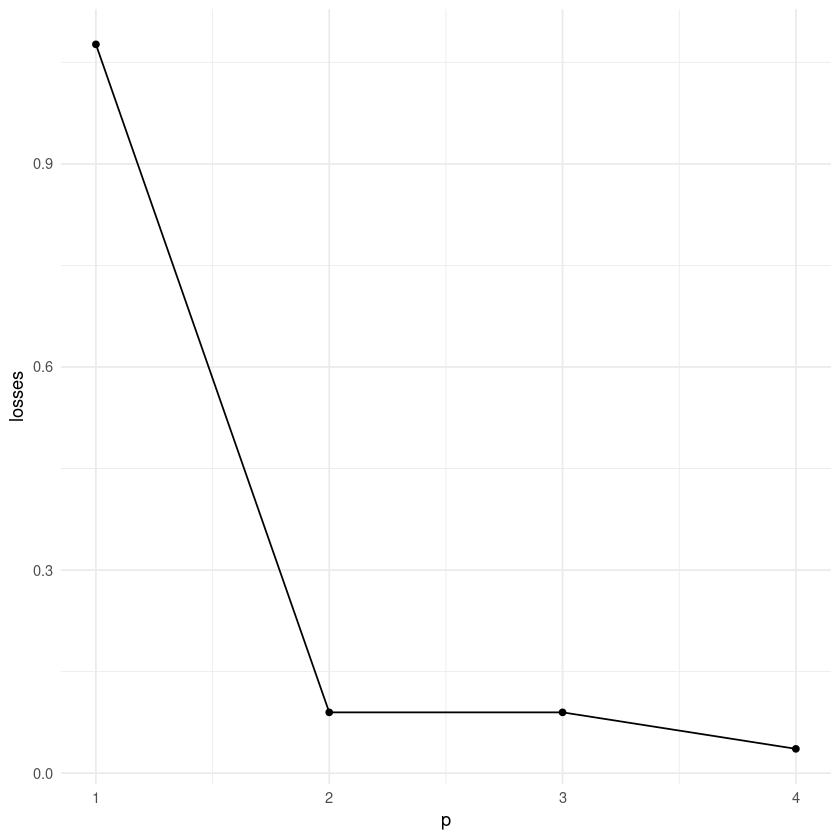

In [22]:
plotdat <- data.frame(p = 1:4, losses = c(
    maxPCA1$loss_fctn_value,
    maxPCA2$loss_fctn_value,
    maxPCA3$loss_fctn_value,
    maxPCA4$loss_fctn_value   
))

pe <- ggplot(aes(x = p, y = losses), data = plotdat) + geom_line() + geom_point() + theme_minimal()
pe

In [23]:
ggsave("genmlm_elbow.pdf", pe)

Saving 6.67 x 6.67 in image


# pairplot to visually inspect reconstruction

In [24]:
datX <- data.frame(X) %>% sample_n(5000)
rec <- t(maxmatmul(maxPCA2$reconstr_matrix, t(as.matrix(datX))))
datX$is_rec = "original"
datrec <- data.frame(rec)
datrec$is_rec = "reconstruction"
names(datrec) <- names(datX)
plot_datX <- full_join(datX, datrec)

Joining with `by = join_by(X1, X2, X3, X4, is_rec)`


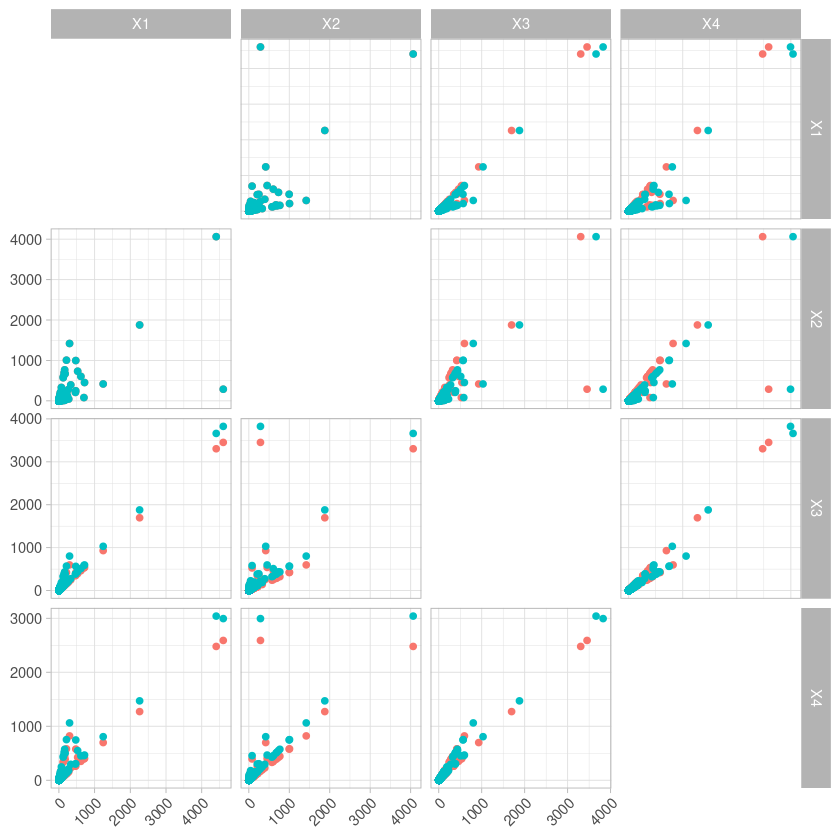

In [25]:
p <- ggpairs(
    plot_datX, 
    aes(color = is_rec),
    columns = 1:4,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p

In [26]:
plot_datX %>% group_by(is_rec) %>% summarize(max(X1))

is_rec,max(X1)
<chr>,<dbl>
original,4603.506
reconstruction,4603.534


In [27]:
ggsave("genmlm.png", p)

Saving 6.67 x 6.67 in image
